In [ ]:
%pylab inline
gray()

In [8]:
import torch

In [9]:
import torchvision

In [10]:
from torchvision.datasets import MNIST

In [11]:
training_data = MNIST('./mndist', train=True,  download=True)

In [12]:
from torchvision import transforms

In [13]:
transform = transforms.Compose(
    [transforms.ToTensor()])

In [14]:
training_data = MNIST('./mndist', train=True,  download=True, transform=transform)

In [16]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=4, shuffle=True, num_workers=2)

In [17]:
train_iter = iter(train_loader)
images, targets = train_iter.next()

In [22]:
import torch.nn as nn
import torch.nn.functional as F

In [23]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(784, 10)
        
    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        a = self.fc(x)
        return a  # Will learn to treat 'a' as the natural parameters of a multinomial distr. 

In [24]:
import torch.optim as optim

net = MyNet()

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # Will discuss lr and momentum later

In [29]:
def show_batch(images, targets, predictions=None):
    ncols = ceil(sqrt(len(images)))
    nrows = ceil(len(images)/ncols)
    for i in range(len(images)):
        subplot(nrows, ncols, i+1)
        imshow(images[i].numpy().squeeze())
        xticks([]); yticks([]); 
        if predictions is not None:
            xlabel("P:{}, T:{}".format( predictions[i].numpy(), targets[i].numpy()))
        elif targets is not None:
            xlabel("T:{}".format(targets[i].numpy()))


In [26]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)               # Predict
        loss = criterion(outputs, labels)   # Grade / Evaluate
        loss.backward()                     # Determine how each parameter effected the loss
        optimizer.step()                    # Update parameters 

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 0.754
[1,  4000] loss: 0.463
[1,  6000] loss: 0.407
[1,  8000] loss: 0.375
[1, 10000] loss: 0.352
[1, 12000] loss: 0.349
[1, 14000] loss: 0.355
[2,  2000] loss: 0.324
[2,  4000] loss: 0.326
[2,  6000] loss: 0.325
[2,  8000] loss: 0.314
[2, 10000] loss: 0.319
[2, 12000] loss: 0.323
[2, 14000] loss: 0.310
Finished Training


In [30]:
y = net(images).argmax(1)

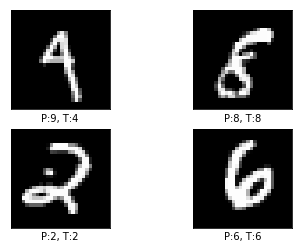

In [31]:
show_batch(images, targets, y)

This was training data

In [55]:
test_data = MNIST('./mndist', train=False,  download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, num_workers=2)

In [56]:
test_iter = iter(test_loader)
image, target = test_iter.next()

In [64]:
y = net(image).argmax(1)

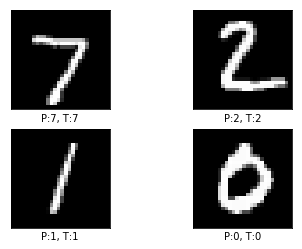

In [65]:
show_batch(image, target, y)

Above was on Test data

In [66]:
with torch.no_grad():
    cm = np.zeros((10,10), dtype=np.int64)
    for x, y in iter(test_loader):
        p = net(x).argmax(1).numpy()
        for pred, true in zip(p, y):
            cm[int(pred), int(true)] += 1

In [67]:
import pandas as pd
df_cm = pd.DataFrame(cm, index = arange(10), columns = arange(10))
df_cm

,0,1,2,3,4,5,6,7,8,9
0,960,0,5,3,2,8,16,2,6,9
1,0,1109,7,1,2,3,3,11,9,6
2,2,2,915,25,3,6,5,23,5,3
3,2,2,15,888,1,19,1,8,22,10
4,1,0,15,0,910,9,17,8,9,39
5,7,3,6,56,0,801,21,0,34,16
6,5,4,11,1,10,10,891,0,10,0
7,1,1,13,14,2,5,2,940,14,25
8,2,14,38,14,7,22,2,2,852,5
9,0,0,7,8,45,9,0,34,13,896


Install $\texttt{seaborn}$ to plot confusion matrices (and many other things) easily.   

In [68]:
import seaborn as sn

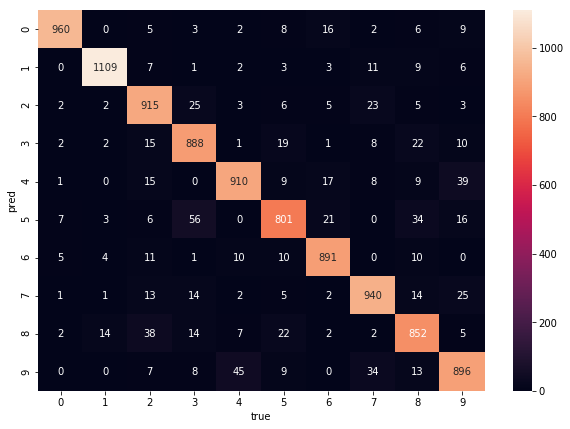

In [69]:
figure(figsize = (10,7))
sn.heatmap(df_cm, fmt='d', annot=True);
ylabel('pred')
xlabel('true');

In [70]:
acc = np.trace(cm)/ np.sum(cm)
acc

0.9162

In [71]:
def report_from_cm(cm, labels, beta=1):
    df = pd.DataFrame(index=list(labels)+['avg/total'], columns=['precision', 'recall', 'fmeasure','support'])
    for i, label in enumerate(labels):
        tp = cm[i,i]
        p = cm[i,:].sum()
        support = cm[:,i].sum()
        fp = p-tp
        fn = support-tp
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        fmeasure = (1+beta**2)*precision*recall/((beta**2)*precision + recall)
        df['precision'][label] = precision
        df['recall'][label] = recall
        df['fmeasure'][label] = fmeasure
        df['support'][label] = support
    df['precision']['avg/total'] = df['precision'][:'avg/total'].mean()
    df['recall']['avg/total'] = df['recall'][:'avg/total'].mean()
    df['fmeasure']['avg/total'] = df['fmeasure'][:'avg/total'].mean()
    df['support']['avg/total'] = df['support'][:'avg/total'].sum()
    return df

In [72]:
report_from_cm(cm, range(10))

,precision,recall,fmeasure,support
0,0.949555,0.979592,0.96434,980
1,0.96351,0.977093,0.970254,1135
2,0.925177,0.886628,0.905492,1032
3,0.917355,0.879208,0.897877,1010
4,0.902778,0.92668,0.914573,982
5,0.848517,0.897982,0.872549,892
6,0.94586,0.930063,0.937895,958
7,0.924287,0.914397,0.919315,1028
8,0.889353,0.874743,0.881988,974
9,0.885375,0.888008,0.88669,1009


In [42]:
torch.save(net.state_dict(), 'mnist-linear.pth.tar')

In [43]:
# To resume later
net.load_state_dict(torch.load('mnist-linear.pth.tar'))